In [1]:
import sys
sys.path.append('/../QmeQ/qmeq/')
#sys.path.append('../qmeq/')
import qmeq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#--SETUP: ---------------------------------------------------------------------------------
epsilons = np.linspace(-100, 100, 10)
omega = 0.1
u_intra = 200
u_inter = 100
V_B = 50
mu_L = -V_B/2       
mu_R = V_B/2        

gammaL = 0.1
gammaR = gammaL
tL = np.sqrt(gammaL/np.pi/2)
tR = np.sqrt(gammaR/np.pi/2)
T_L = 4
T_R = 1
n = 4
nleads = 4

U = {(0,1,1,0):u_intra, (2,3,3,2):u_intra, (0,2,2,0):u_inter, (0,3,3,0):u_inter, (1,2,2,1):u_inter, (1,3,3,1):u_inter } 
mulst = {0:mu_L, 1:mu_L, 2:mu_R, 3:mu_R}
tlst = {0:T_L, 1:T_L, 2:T_R, 3:T_R}

if T_L < T_R:
    raise SystemExit("Not my convention! (T_L < T_R) so cell was shut down")
elif T_L > T_R:
    T_COLD = T_R
    T_HOT = T_L
elif T_L == T_R:
    raise SystemExit("Not a heat engine (T_L = T_R) so cell was shut down")

In [3]:
#Från series till parallel!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#series: omega = 1, tL* = 0:   lamda = 0
#parallel: omega = 0, tL* = 1:  lamda = 1
#lmda : 0 -> 1
lamdas = np.linspace(0,1,12)
I = []
I_var = []
J_QH = []
heat_engine_epsilons = []

#system = qmeq.Builder(nsingle=n, coulomb=U, nleads=nleads,
#                        mulst=mulst, tlst=tlst, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')


for l_idx, lmda in enumerate(lamdas):
    QH_s = []
    I_s = []
    I_vars = []
    heat_epses = []
    for e_idx, eps in enumerate(epsilons):
        system = qmeq.Builder(nsingle=n, hsingle={(0,0):eps, (1,1):eps, (2,2):eps+1, (3,3):eps+1, (0,2):(1-lmda)*omega, (1,3):(1-lmda)*omega}, coulomb=U, nleads=nleads,
                        mulst=mulst, tlst=tlst, tleads={(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):lmda*tL, (1,3):lmda*tL, (2,0):lmda*tR, (3,1):lmda*tR},
                        dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
        #system.change(hsingle={(0,0):eps, (1,1):eps, (2,2):eps+1, (3,3):eps+1, (0,2):(1-lmda)*omega, (1,3):(1-lmda)*omega})
        #system.change(tleads={(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):lmda*tL, (1,3):lmda*tL, (2,0):lmda*tR, (3,1):lmda*tR})
        system.solve()
        if system.current_noise[1] < 0:
            print(system.current_noise[1], lmda, eps)
        j_qh = system.heat_current[0]+system.heat_current[1]
        i = system.current_noise[0]
        if j_qh > 0 and i > 0:
            QH_s.append(j_qh)
            I_s.append(i)
            I_vars.append(system.current_noise[1])
            heat_epses.append(eps)
        #print(system.heat_current, lmda, eps)

    J_QH.append(QH_s)
    I.append(I_s)
    I_var.append(I_vars)
    heat_engine_epsilons.append(heat_epses)
    
'''
print(len(J_QH))
print(len(J_QH[0]))
print(len(I))
print(len(I[1]))
print(len(I_var))
print(len(I_var[2]))
'''
print(heat_engine_epsilons)


[[np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)]]


In [ ]:
#Calculations of P, efficiency, sigma and TUR
is_equal = all(row == heat_engine_epsilons[0] for row in heat_engine_epsilons)
if not is_equal:
    raise SystemExit("~~~ Not the same heat engine epsilons for all lambdas! This must be handled ~~~")

J_QH = np.array(J_QH)
I = np.array(I)
I_var = np.array(I_var)

P = I*V_B
#print(P)
eff_carnot = 1-(T_COLD/T_HOT)
#print(eff_carnot)
eff = P/J_QH
#print(eff)
sigma = P*(1/T_COLD)*(eff_carnot-eff)/eff
TUR = I_var*sigma/(I**2)


[[6.08020667e-12 2.35061374e-14 9.08728501e-17]
 [8.74704434e-12 3.38158502e-14 1.30729376e-16]
 [2.15252101e-11 8.32161364e-14 3.21706938e-16]
 [4.34256663e-11 1.67883374e-13 6.49023719e-16]
 [7.26372324e-11 2.80815514e-13 1.08561035e-15]
 [1.06901894e-10 4.13283033e-13 1.59771920e-15]
 [1.43948536e-10 5.56505751e-13 2.15140679e-15]
 [1.81825705e-10 7.02939321e-13 2.71750728e-15]
 [2.19062328e-10 8.46896551e-13 3.27403443e-15]
 [2.54677865e-10 9.84586658e-13 3.80633339e-15]
 [2.88105454e-10 1.11381816e-12 4.30593205e-15]
 [3.19086917e-10 1.23359294e-12 4.76897178e-15]]


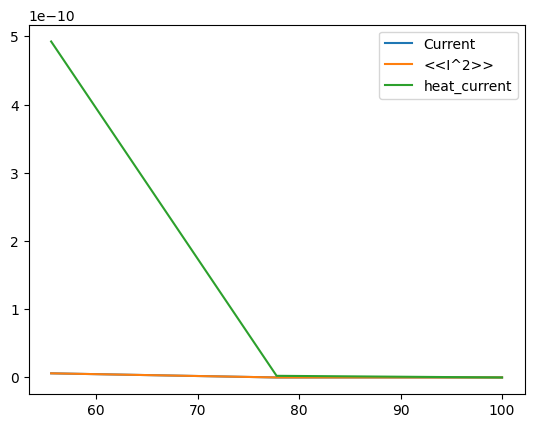

In [5]:
heat_engine_epsilons = np.array(heat_engine_epsilons)

plt.plot(heat_engine_epsilons[0], I[0], label='Current')
plt.plot(heat_engine_epsilons[0], I_var[0], label='<<I^2>>')
plt.plot(heat_engine_epsilons[0], J_QH[0], label='heat_current')
plt.legend()
plt.show()

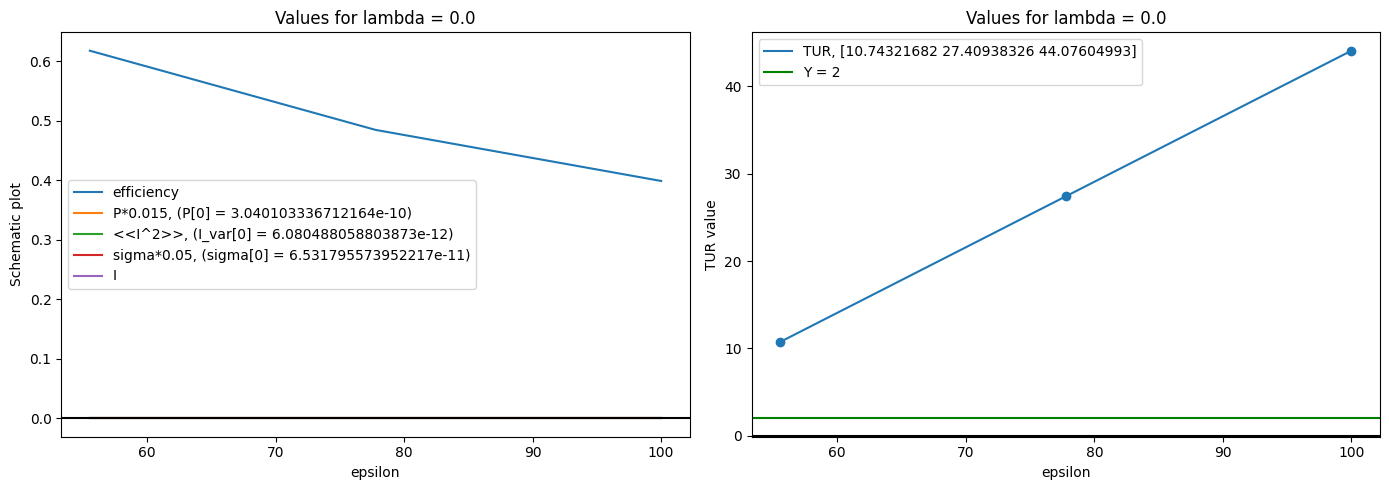

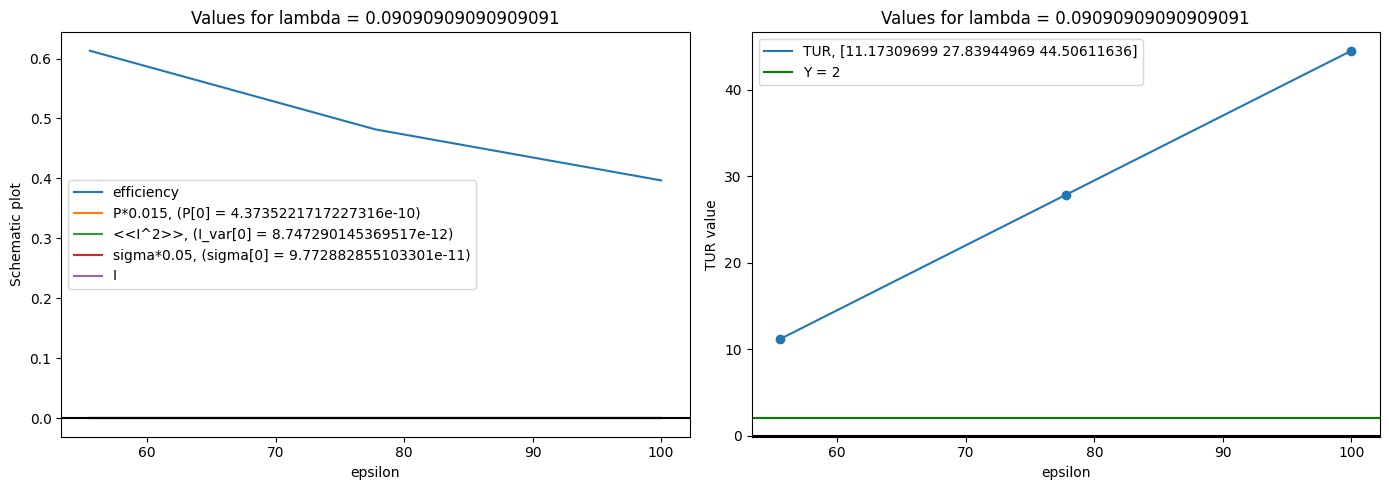

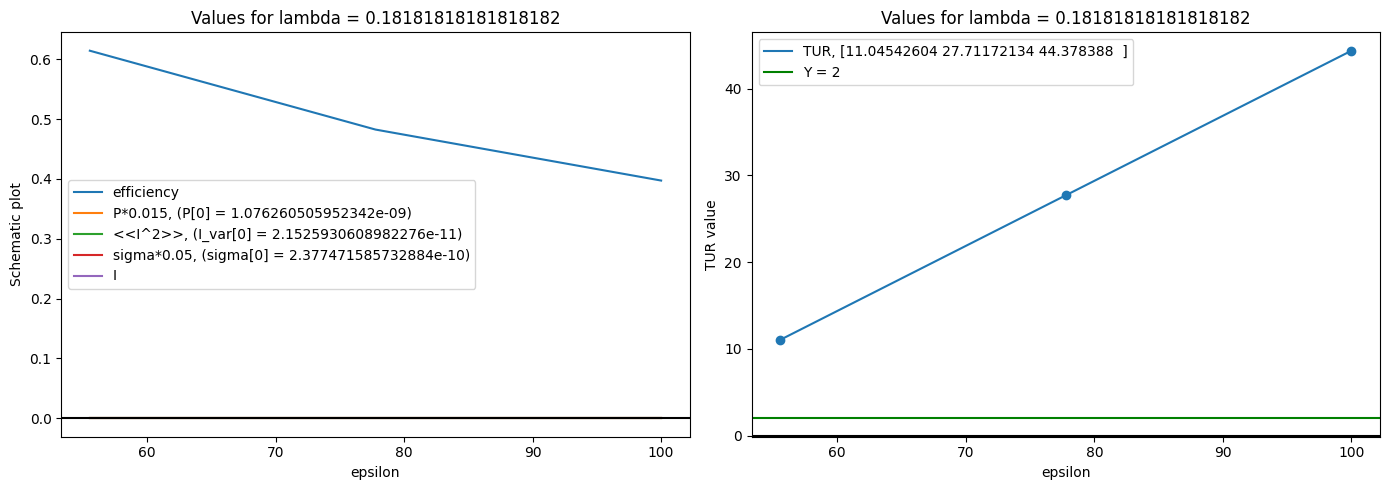

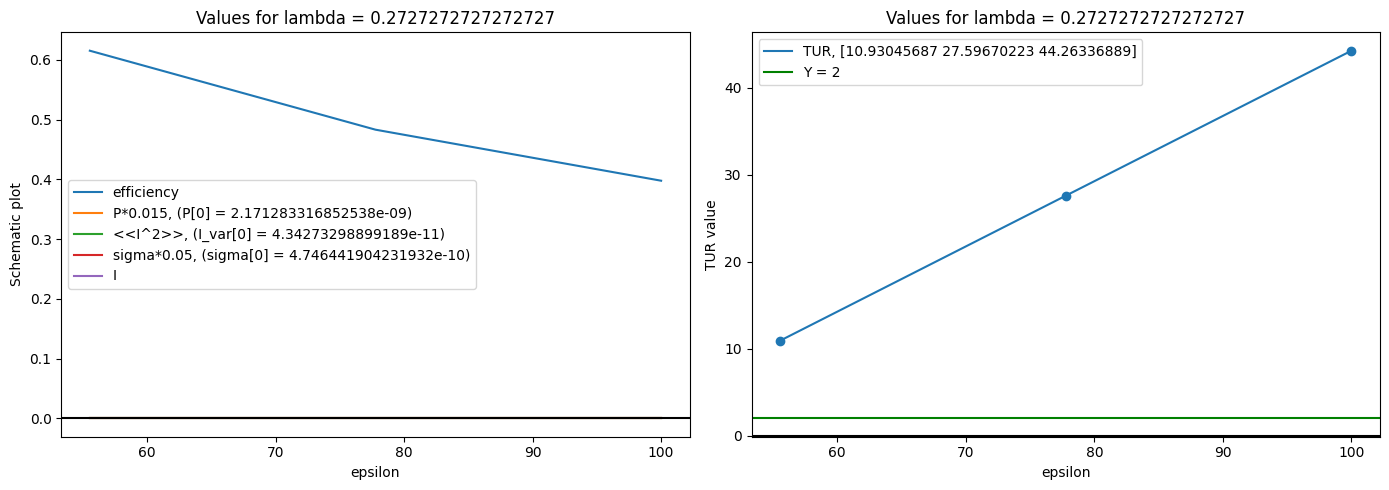

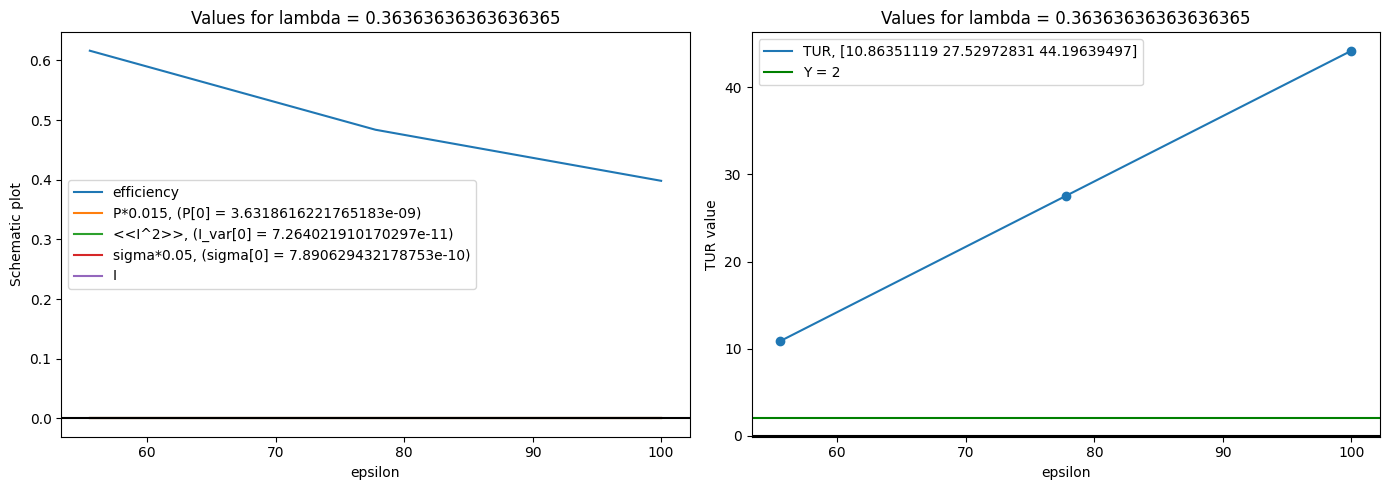

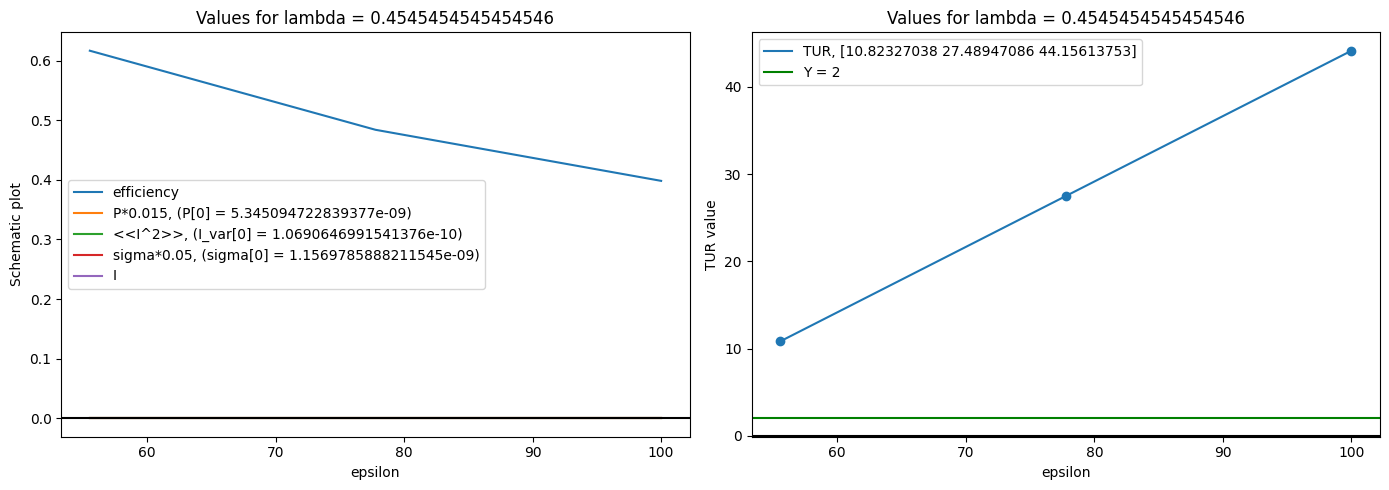

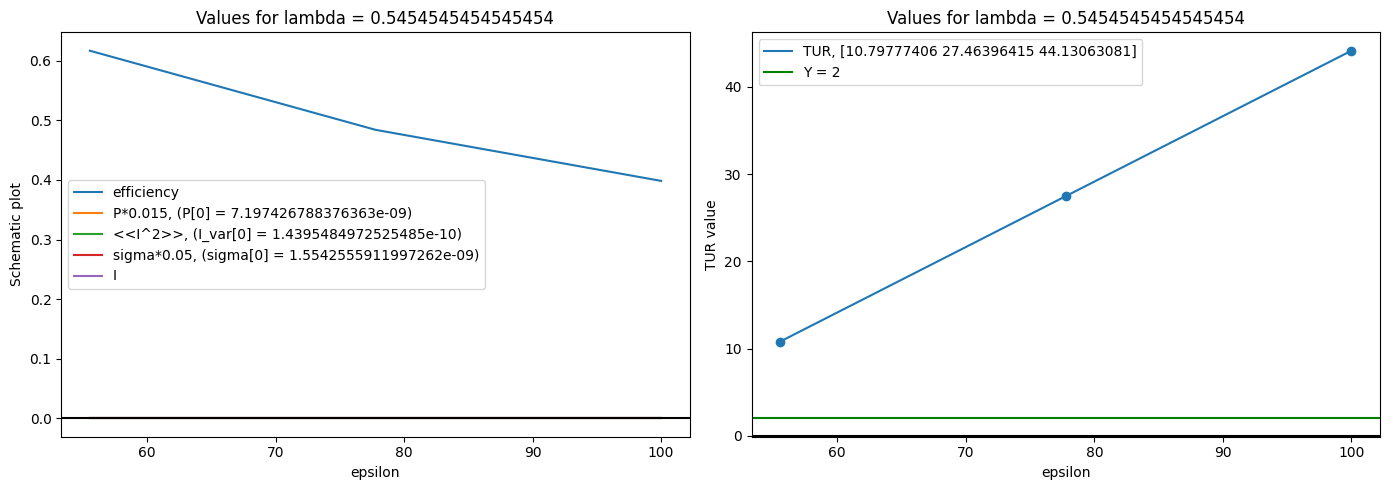

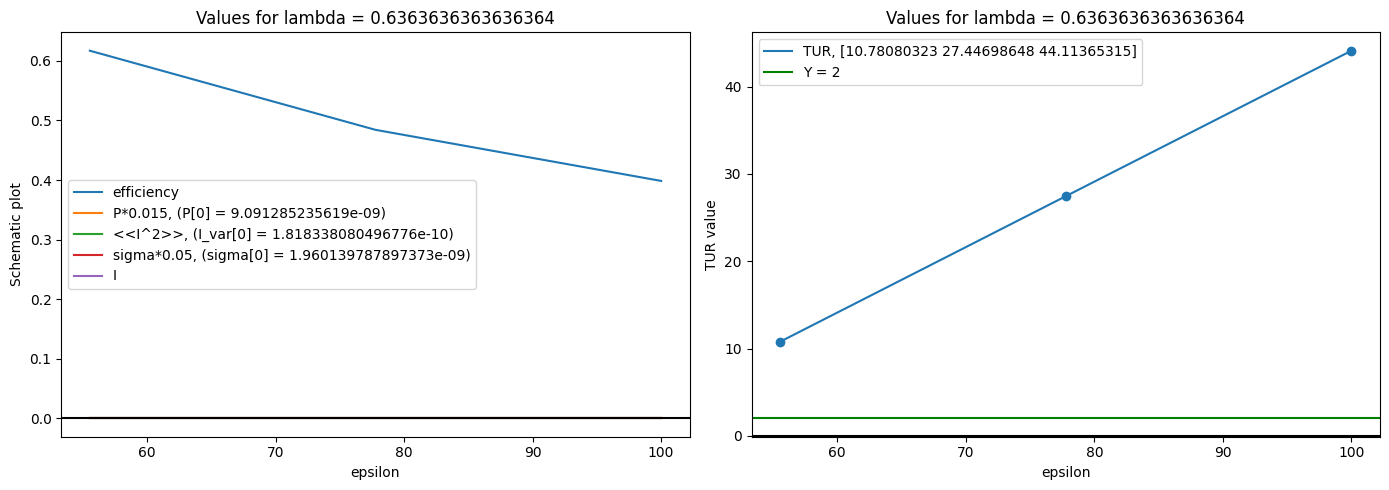

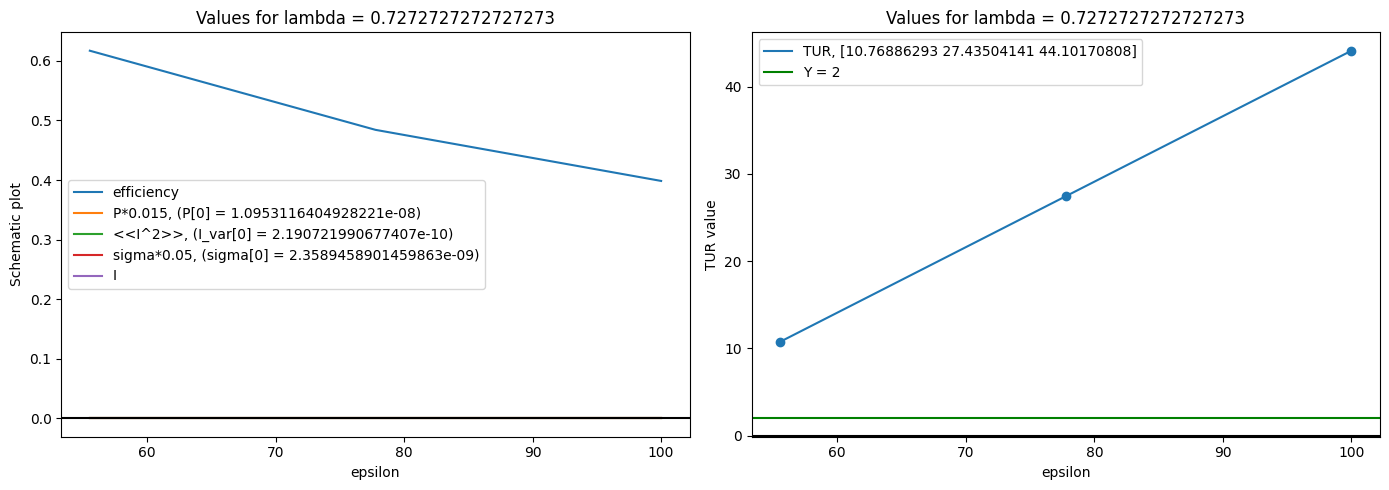

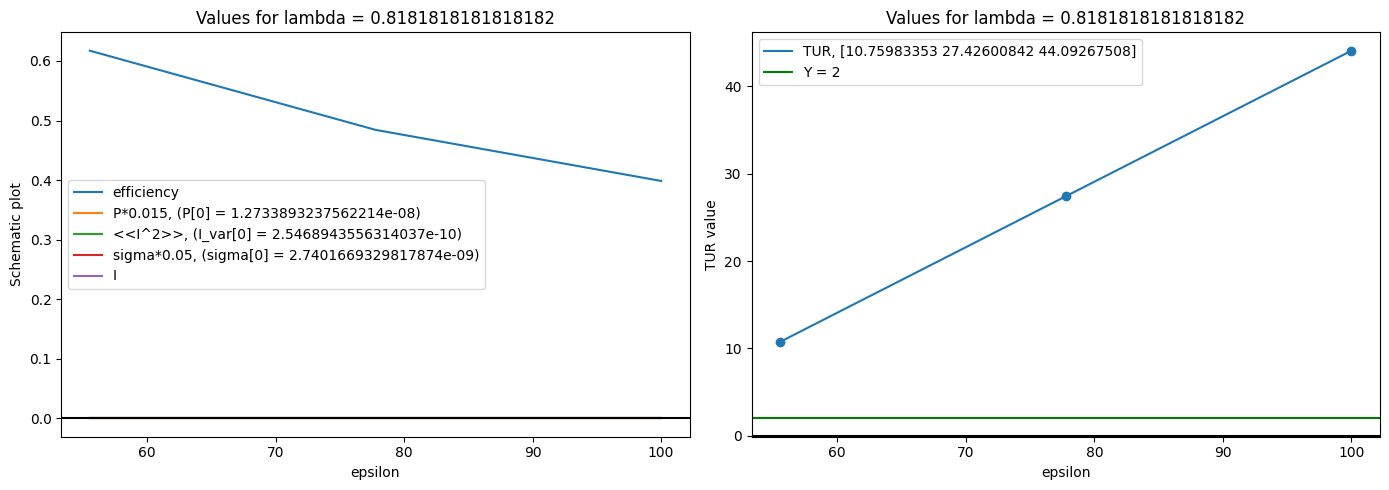

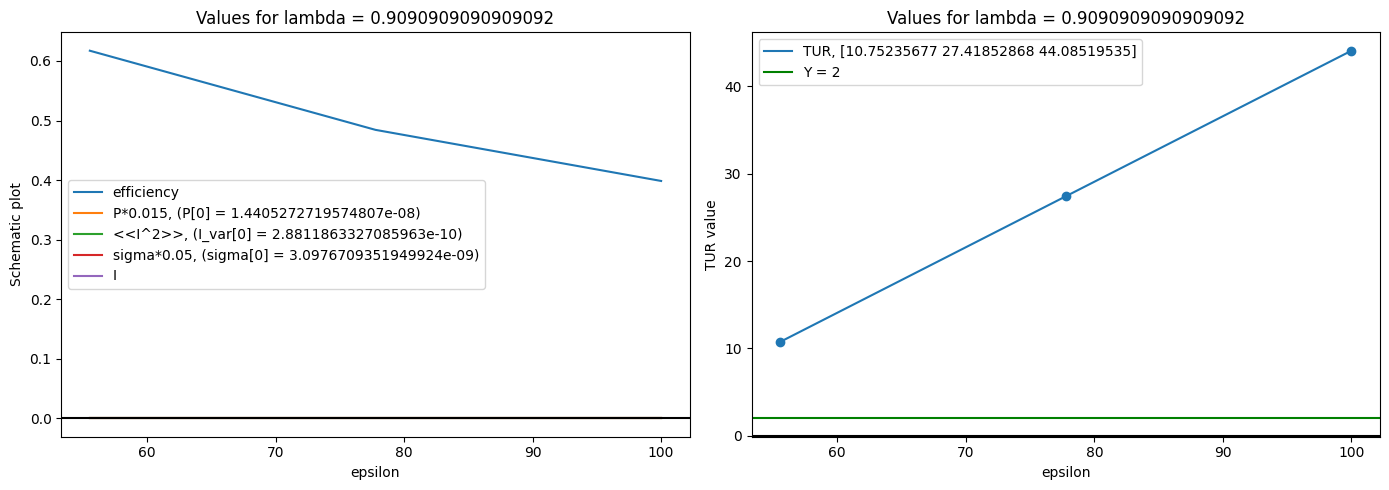

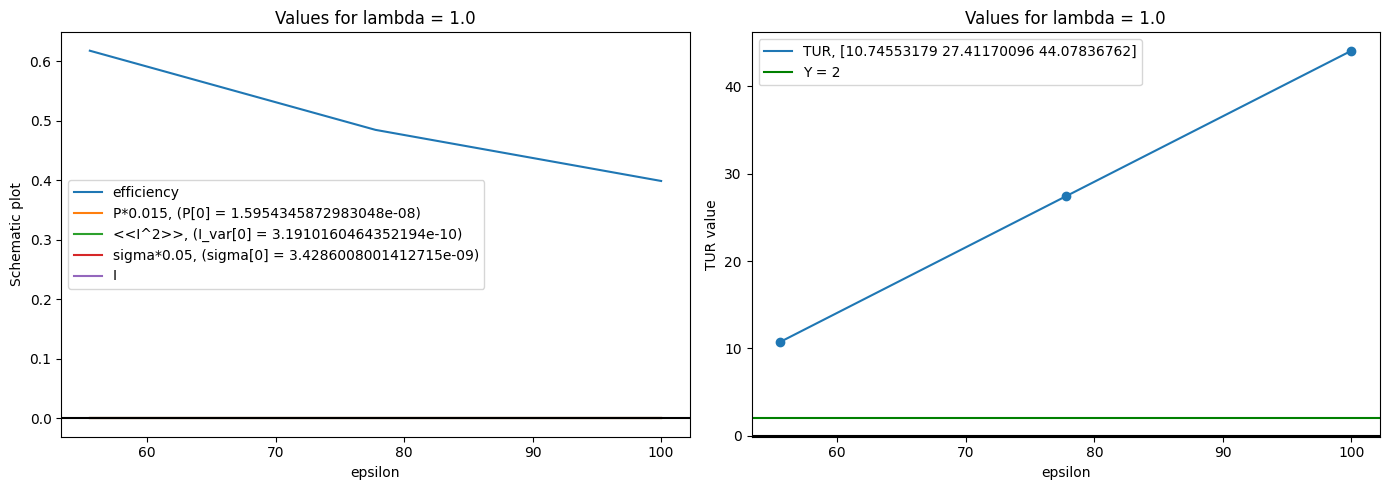

In [13]:
#---------plotting----------------------------------
for idx, lmda in enumerate(lamdas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 

    ax1.plot(heat_engine_epsilons[idx], eff[idx], label='efficiency')
    ax1.plot(heat_engine_epsilons[idx], 0.015*P[idx], label=f'P*0.015, (P[0] = {P[idx][0]})')
    ax1.plot(heat_engine_epsilons[idx], I_var[idx], label=f'<<I^2>>, (I_var[0] = {I_var[idx][0]})')
    ax1.plot(heat_engine_epsilons[idx], 0.05*sigma[idx], label=f'sigma*0.05, (sigma[0] = {sigma[idx][0]})')
    ax1.plot(heat_engine_epsilons[idx], I[idx], label='I')
    #ax1.scatter(epsilons, J_QH[idx], label=f'J_QH, 0: {J_QH[idx][0]}, 1: {J_QH[idx][1]}, 2: {J_QH[idx][2]} , 3: {J_QH[idx][3]}, 4: {J_QH[idx][4]}, 5: {J_QH[idx][5]}, 6: {J_QH[idx][6]}')
    ax1.axhline(y=0, color='black', linestyle='-')
    #ax1.set_ylim(-0.01, 0.01)
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('Schematic plot')
    ax1.set_title(f'Values for lambda = {lmda}')
    ax1.legend()

    ax2.plot(heat_engine_epsilons[idx], TUR[idx], label=f'TUR, {TUR[idx]}')
    ax2.scatter(heat_engine_epsilons[idx], TUR[idx])
    ax2.set_title(f'Values for lambda = {lmda}')
    ax2.axhline(y=2, color='g', linestyle='-', label= 'Y = 2')
    ax2.axhline(y=0, color='black', linestyle='-')
    ax2.set_xlabel('epsilon')
    ax2.set_ylabel('TUR value')
    ax2.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

I: (12, 3)
meshgrid:
epsilon: (12, 3)
lamda: (12, 3)


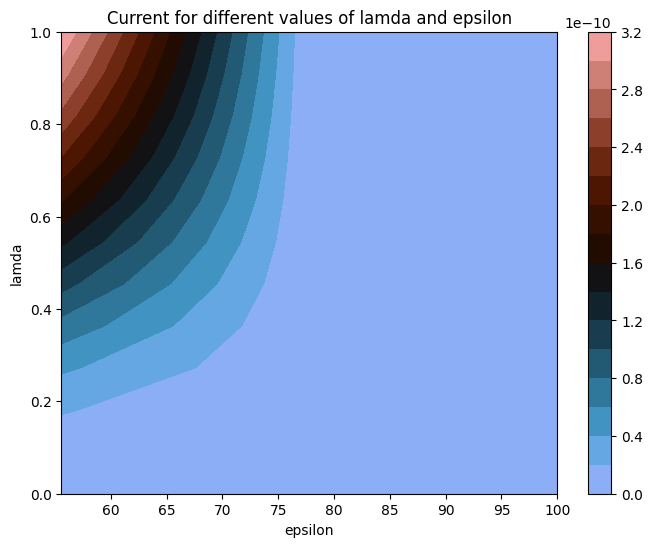

In [7]:
# Plotting of the cummulants

# Create a mesh grid
epsilon, lamda = np.meshgrid(heat_engine_epsilons[0], lamdas)
print('I:',I.shape)
print('meshgrid:')
print('epsilon:', epsilon.shape)
print('lamda:', lamda.shape)

plt.figure(figsize=(8, 6))
# Create a contour plot (or a pcolormesh plot for a smooth color gradient)
contour = plt.contourf(epsilon, lamda, I, 20, cmap='berlin')  # Adjust number of contour levels as needed
#contour = plt.pcolormesh(epsilon, lamda, I, shading='auto', cmap='viridis')
plt.colorbar(contour)
plt.xlabel('epsilon')
plt.ylabel('lamda')
plt.title('Current for different values of lamda and epsilon')
plt.show()